In [3]:
import numpy as np
import pandas as pd
import pickle
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import  mean_squared_error, r2_score
from collections import Counter

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV

import statsmodels.api as sm

In [13]:
# %load 'src/pipeline.py'
import numpy as np
import pandas as pd
import pickle
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
# %matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import  mean_squared_error, r2_score
from collections import Counter

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV

import statsmodels.api as sm

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platf

In [18]:
def price_xform(dframe,colname):
    dframe[colname]=dframe[colname].str.replace('$','')
    dframe[colname]=dframe[colname].str.replace(',','')
    dframe[colname]=pd.to_numeric(dframe[colname])
    #return(dframe)

def cat_rename(dframe,colname,src,tgt):
    dframe[colname]=dframe[colname].str.replace(src,tgt)
    #     dframe[colname]=dframe[colname].str.replace(',','')
    #     dframe[colname]=pd.to_numeric(dframe[colname])
    #     return(dframe)

def create_dummies(dframe,colname):
    #     dfnew=dframe.copy()
    dframe=pd.get_dummies(data=dframe, columns=[colname])# create dummies and drop the parent column
    dframe.drop(columns=[dframe.columns[-1]],inplace=True) #dropped the last column from the add dummies
    return dframe

def impute_nullrows(dframe,colname):
    #Impute Null Rows based on the specified column
    print(dframe[colname].isnull().sum())
    dftmp=dframe[~dframe[colname].isnull()]   # remove nulls from one column
    print(dftmp[colname].isnull().sum())
    return dftmp

def init():
    pd.set_option('display.max_columns', 16)
    pd.set_option('display.max_rows', 96)

def read_data():
    print('\nREADING INPUT DATASET .................')
    cal = pd.read_csv('calendar.csv.gz')
    listd = pd.read_csv('listings.csv.gz')
    lists = pd.read_csv('listings.csv')
    revs = pd.read_csv('reviews.csv.gz')
    nhood = pd.read_csv('neighbourhoods.csv')
    purelst = pd.read_csv('listings.csv.gz')
    # print(lists.head())

    print(cal.date.min(),cal.date.max())
    print(revs.date.min(),revs.date.max())

    return(listd)

def process_data(listd,dropzips):
    print('\nPROCESSING INPUT DATASET .................')
    # print(listd.head())

    #!!! APPLY the same for the test data also

    #CLEANING UP INPUT DATASET
    listd_drop_cols = ['scrape_id','last_scraped','experiences_offered','thumbnail_url','medium_url','xl_picture_url',\
                   'host_name','host_location','neighbourhood_group_cleansed','square_feet',\
                   'maximum_nights','is_business_travel_ready']
    # listd_numc_cols  # Numeric Columns
    # listd_catz_cols  # Categorical Columns
    # print('Shape of Input Dataset',len(listd.columns), len(listd_drop_cols))
    listd.drop(listd_drop_cols,axis=1,inplace=True )
    # print('Shape of Output Dataset'len(listd.columns), len(listd_drop_cols))

    # Convert to Booleans
    listd['host_is_superhost'] = listd.apply(lambda x:  x.host_is_superhost=='t', axis= 1)
    listd['host_has_profile_pic'] = listd.apply(lambda x:  x.host_has_profile_pic=='t', axis= 1)
    listd['host_identity_verified'] = listd.apply(lambda x:  x.host_identity_verified=='t', axis= 1)
    listd['instant_bookable'] = listd.apply(lambda x:  x.instant_bookable=='t', axis= 1)

    #Transform all the price columns to remove "$" and ","
    price_xform(listd,'price')
    price_xform(listd,'weekly_price')
    price_xform(listd,'monthly_price')
    price_xform(listd,'security_deposit')
    price_xform(listd,'cleaning_fee')
    price_xform(listd,'extra_people')

    #Transform the room_type . to create a meaningful name and create dummies
    cat_rename(listd,'room_type','Entire home/apt','full')
    cat_rename(listd,'room_type','Private room','pvt')
    cat_rename(listd,'room_type','Shared room','shared')
    listd=create_dummies(listd,'room_type')

    #Transform the bed_type . to create a meaningful name and create dummies
    listd['bed_type'] = listd.apply(lambda x: x.bed_type=='Real Bed', axis=1)

    #Put a count on amenities,   IF it does not work, pick the most important feature
    listd['amentcnt'] =   listd.apply(lambda x: len(x.amenities.split(",")), axis=1)

    #Impute the to remove the rows with no zipcode.  !!! APPLY the same for the test data also
    listd=listd[~listd['zipcode'].isnull()]   # remove nulls from one column

    #Impute the null values with meaningful data
    listd['cleaning_fee']=listd['cleaning_fee'].fillna(0)
    listd['review_scores_cleanliness'] = listd['review_scores_cleanliness'].fillna(listd.review_scores_cleanliness.mean())
    listd['review_scores_location'] = listd['review_scores_location'].fillna(listd.review_scores_location.mean())
    listd['review_scores_value'] = listd['review_scores_value'].fillna(listd.review_scores_value.mean())

    listd.loc[listd['minimum_nights']<=7,'min_night_stay'] = 'short'
    listd.loc[(listd['minimum_nights']>7) & (listd['minimum_nights']<=32),'min_night_stay'] = 'mid'
    listd.loc[listd['minimum_nights']>32,'min_night_stay'] = 'long'
    listd=create_dummies(listd,'min_night_stay')

    #Condensing the property_type to sub categories
    listd.loc[listd['property_type']=='Apartment', 'ppt_condensed'] = 'apt'
    listd.loc[listd['property_type']=='Condominium', 'ppt_condensed'] = 'apt'
    listd.loc[listd['property_type']=='Guest suite', 'ppt_condensed'] = 'apt'
    listd.loc[listd['property_type']=='Townhouse', 'ppt_condensed'] = 'apt'
    listd.loc[listd['property_type']=='Guesthouse', 'ppt_condensed'] = 'apt'
    listd.loc[listd['property_type']=='Tiny house', 'ppt_condensed'] = 'apt'
    listd.loc[listd['property_type']=='Timeshare', 'ppt_condensed'] = 'apt'
    listd.loc[listd['property_type']=='Serviced apartment', 'ppt_condensed'] = 'aptspl'
    listd.loc[listd['property_type']=='Bed and breakfast', 'ppt_condensed'] = 'aptspl'
    listd.loc[listd['property_type']=='Treehouse', 'ppt_condensed'] = 'aptspl'
    listd.loc[listd['property_type']=='Cabin', 'ppt_condensed'] = 'aptspl'
    listd.loc[listd['property_type']=='Bus', 'ppt_condensed'] = 'auto'
    listd.loc[listd['property_type']=='Boat', 'ppt_condensed'] = 'auto'
    listd.loc[listd['property_type']=='Camper/RV', 'ppt_condensed'] = 'auto'
    listd.loc[listd['property_type']=='Hostel', 'ppt_condensed'] = 'hostel'
    listd.loc[listd['property_type']=='Boutique hotel', 'ppt_condensed'] = 'hotel'
    listd.loc[listd['property_type']=='Hotel', 'ppt_condensed'] = 'hotel'
    listd.loc[listd['property_type']=='Resort', 'ppt_condensed'] = 'hotel'
    listd.loc[listd['property_type']=='Aparthotel', 'ppt_condensed'] = 'hotel'
    listd.loc[listd['property_type']=='House', 'ppt_condensed'] = 'house'
    listd.loc[listd['property_type']=='Bungalow', 'ppt_condensed'] = 'house'
    listd.loc[listd['property_type']=='Cottage', 'ppt_condensed'] = 'house'
    listd.loc[listd['property_type']=='Villa', 'ppt_condensed'] = 'house'
    listd.loc[listd['property_type']=='Other', 'ppt_condensed'] = 'other'
    listd.loc[listd['property_type']=='Loft', 'ppt_condensed'] = 'room'

    listd=create_dummies(listd,'ppt_condensed')

    if(dropzips):
#         listd.drop('zipcode',axis=1,inplace=True)
        print('inside dropzips')
    else:
        print('inside not dropzips')
        listd=listd[listd.zipcode!='-- default zip code --']
        listd=create_dummies(listd,'zipcode')

    #imputing some more missing values
    listd['cleaning_fee'].fillna(0, inplace=True)
    listd['beds'].fillna(0, inplace=True)
    listd['bathrooms'].fillna(0, inplace=True)

    #Imputed the rows with price is equal to zero
    listd=listd[listd.price>0]

    listd_drop_cols2=['id', 'listing_url', 'name', 'summary', 'space', 'description',\
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',\
       'house_rules', 'picture_url', 'host_id', 'host_url', 'host_since',\
       'host_about', 'host_response_time', 'host_response_rate',\
       'host_acceptance_rate', 'host_thumbnail_url',\
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',\
       'host_total_listings_count', 'host_verifications',\
       'host_has_profile_pic', 'street',\
       'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',\
       'market', 'smart_location', 'country_code', 'country', 'latitude',\
       'longitude', 'is_location_exact', 'property_type',\
       'amenities',\
       'weekly_price', 'monthly_price', 'security_deposit',\
       'extra_people', 'minimum_nights', 'calendar_updated',\
       'has_availability', 'availability_30', 'availability_60',\
       'availability_90', 'availability_365', 'calendar_last_scraped',\
       'number_of_reviews', 'first_review', 'last_review',\
       'review_scores_rating', 'review_scores_accuracy',\
       'review_scores_cleanliness', 'review_scores_checkin',\
       'review_scores_communication', 'review_scores_location',\
       'review_scores_value', 'requires_license', 'license',\
       'jurisdiction_names', 'instant_bookable', 'cancellation_policy',\
       'require_guest_profile_picture', 'require_guest_phone_verification',\
       'calculated_host_listings_count', 'reviews_per_month']
    listd.drop(listd_drop_cols2,axis=1,inplace=True )

    listd['host_is_superhost'] = (listd['host_is_superhost'] == True).astype(int)
    listd['host_identity_verified'] = (listd['host_identity_verified'] == True).astype(int)
    listd['bed_type'] = (listd['bed_type'] == True).astype(int)

    print(listd.shape)
    return(listd)

def create_database(dfclean):
    print('\nCREATING A CLEAN TRAIN TEST DATASET .................')
    print(dfclean.shape)
    print(dfclean.head())

    y= dfclean.price
    X= dfclean.copy()
    X=X.drop(['price'],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=47)
    print(X_train.shape, X_test.shape)
    print(y_train.shape, y_test.shape)

    X_train.to_pickle('pklz/rand_split/X_train.pkl')
    y_train.to_pickle('pklz/rand_split/y_train.pkl')
    X_test.to_pickle('pklz/rand_split/X_test.pkl')
    y_test.to_pickle('pklz/rand_split/y_test.pkl')

    dfclean_lt_500=dfclean[dfclean.price<500]
    dfclean_gt_500=dfclean[dfclean.price>500]
    dfclean_gt_500=dfclean_gt_500[dfclean_gt_500.price<1500]

    y=dfclean_lt_500.price
    X=dfclean_lt_500.copy()
    X=X.drop(['price'],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=47)

    X_train.to_pickle('pklz/price_split/X_lt_train.pkl')
    y_train.to_pickle('pklz/price_split/y_lt_train.pkl')
    X_test.to_pickle('pklz/price_split/X_lt_test.pkl')
    y_test.to_pickle('pklz/price_split/y_lt_test.pkl')


    y=dfclean_gt_500.price
    X=dfclean_gt_500.copy()
    X=X.drop(['price'],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=47)

    X_train.to_pickle('pklz/price_split/X_gt_train.pkl')
    y_train.to_pickle('pklz/price_split/y_gt_train.pkl')
    X_test.to_pickle('pklz/price_split/X_gt_test.pkl')
    y_test.to_pickle('pklz/price_split/y_gt_test.pkl')

def del_regr_plot(y_act,y_pred,mdl_data):
    #Building Residual DF

    dfpred= y_act.to_frame()
    dfpred['preds'] = y_pred
    dfpred['resid'] = dfpred.preds-dfpred.price
    dfpred['residpct'] = (dfpred.preds-dfpred.price)/dfpred.price*100
    # dfpred.head()
    resids=y_pred-y_test

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)

    ax1.scatter(y_act, y_pred,  color='black')
    ax1.set_title('act_vs_pred')
    ax1.set_xlabel('PRICE')
    ax1.set_ylabel('PREDICT')

    ax2.scatter(y_act,resids, color='red')
    ax2.set_title('RESIDUALS',)
    ax2.set_xlabel('PRICE')
    ax2.set_ylabel('RESIDUAL')

    ax3.scatter(y_act,resids/y_test*100, color='blue')
    ax3.set_title('RESIDUAL PCT')
    ax3.set_xlabel('PRICE')
    ax3.set_ylabel('RESIDUAL PCT')

    fig.suptitle('mdl_data', fontsize=12, y=1.2)
    fig.tight_layout()

    fig1 = plt.gcf()
    fig1.savefig('plots/'+'RESI_'+mdl_data+'.png', format='png')

def regr_plot(y_act,y_pred,mdl_data):
    #Building Residual DF

    dfpred= y_act.to_frame()
    dfpred['preds'] = y_pred
    dfpred['resid'] = dfpred.preds-dfpred.price
    dfpred['residpct'] = (dfpred.preds-dfpred.price)/dfpred.price*100
    # dfpred.head()
    resids=y_pred-y_test

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)

    ax1.scatter(y_pred, y_act,  color='black')
    ax1.set_title('act_vs_pred')
    ax1.set_xlabel('PREDICT')
    ax1.set_ylabel('PRICE')

    ax2.scatter(y_pred,resids, color='red')
    ax2.set_title('RESIDUALS',)
    ax2.set_xlabel('PREDICT')
    ax2.set_ylabel('RESIDUAL')

    ax3.scatter(y_pred,resids/y_test*100, color='blue')
    ax3.set_title('RESIDUAL PCT')
    ax3.set_xlabel('PREDICT')
    ax3.set_ylabel('RESIDUAL PCT')

#     fig.suptitle(mdl_data, fontsize=12, y=1.2)
#     fig.suptitle(mdl_data, color='b',fontsize=12, y=1)
    plt.suptitle('MODEL INFO : '+mdl_data, color='b',fontsize=12, y=1.2)
    fig.tight_layout()

    fig1 = plt.gcf()
    fig1.savefig('plots/'+'RESI_'+mdl_data+'.png', format='png')

def plot_feature_importance(featurelist,featureimp,name):
    tmp_df=featurelist.to_frame(index=False)
    tmp_df=tmp_df.rename(columns={0:'feature'})
    tmp_df['prime']=featureimp
    feature_df=tmp_df.sort_values(by=['prime'], ascending=True)
    fig=plt.figure(figsize=(8,10))
    ax1=fig.add_subplot(111)
    ax1.barh(feature_df['feature'],feature_df['prime'],color='rgbkymc')
    fig.suptitle(name, fontsize=12, y=1.2)
    fig.tight_layout()
    fig1 = plt.gcf()
    fig1.savefig('plots/'+'FI_'+name+'.png', format='png')

def my_metrics(y_act,y_pred,mdl_data):
    r2= (1 - (((y_act-y_pred)**2).sum()) / (((y_act-y_act.mean())**2).sum()) )
    r2_score= (1 - ((y_act-y_pred)**2).sum() / ((y_act-y_act.mean())**2).sum() )
    mse =  ((y_act-y_pred) ** 2).sum()/len(y_act)
    rmse = mse ** 0.5
    rmsle = np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_act))**2))
    mspct = np.abs(((y_act-y_pred)/y_act)).mean()


    mse_prop = (np.mean(np.abs((y_act - y_pred)**2 / (y_act+1)**2  )) * 100) **0.5

    #Calculate the baseline errors
    baseline = abs(y_act.mean()-y_act)
    #Calculate the absolute errors
    residuals = abs(y_pred-y_test)
    #Calculate Mean Absolute pct error
    mape = (residuals/y_test)*100
    #Accuracy 
    accy=100-np.mean(mape)
    #Mean Absolute Error 
    
    print('\n   **************** Metrics for : ',mdl_data,' *******************')
    print("   R2 (Variance Squared ERROR)                   = %.4f"%r2)
    print("   MSE (Mean Squared ERROR)                      = %.4f"%mse)
    print("   RMSE (ROOT Mean Squared ERROR)                = %.4f"%rmse)
    print("   RMSLE (ROOT Mean Squared Logrithmic ERROR)    = %.4f"%rmsle)
    print("   PCTE  (Percent Absolute Error)                = %.4f\n"%mspct)

    print("   Baseline Mean Absolute Error                  =",np.mean(baseline))
    print("   Predicted Mean Absolute Error                 =",np.mean(residuals))
    print("   Accuracy  (100-MAPE mean absolute PCT ERR)    =",round(accy,2), '%')

    print('\n   **************** -------------------------- *******************',len(y_act), mse_prop)
    # print(len(y_act), mse_prop)

    # regr_plot(y_act,y_pred,mdl_data)
    return(r2,rmse,rmsle,mspct)

def evaluate(model, test_features, test_labels):
    #EVALUATE THE RANDOM SEARCH BEST PARAMETERS
    predictions = model.predict(test_features)
    rfcv_score = model.score(test_features, test_labels)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    # print('Model Performance')
    print('   R2 Score = {:0.2f}.'.format(rfcv_score))
    print('   Average Error: {:0.4f}'.format(np.mean(errors)))
    print('   Accuracy = {:0.2f}%.'.format(accuracy))
    # print('   My R2 Score is : ',my_metric(test_labels,predictions))
    return(accuracy)

def estimate_tree(mdl,X_train, y_train,X_test,y_test,name):
    treelist=[1,5,10,15,25,50,100,150,200,250,300,400,500,700,900,1200,1500,1800,2000]
    mdl_score=[]
    for trees in treelist:
    # for trees in range(25,300,25):
        mdl.n_estimators = trees
        mdl.fit(X_train, y_train)
        mscore=mdl.score(X_test,y_test)
        print('         ',trees, mscore)
        mdl_score.append(mscore)
        
    print(treelist,mdl_score)
#     print(mdl.name)
    plt.figure(figsize=(12,10))
    plt.plot(treelist, mdl_score, 'o--')
    #plt.plot(np.linspace(0,1), np.linspace(0,1), 'k--')
    plt.ylabel("Score",  fontsize=14)
    plt.xlabel("Estimators", fontsize=14)
    
#     fig_et.tight_layout()
    fig_et = plt.gcf()
    fig_et.savefig('plots/'+'nEsti_'+name+'.png', format='png')
    

def run_randforest(X_train,y_train,X_test,y_test,name):
    print('\nRUNNING RANDOM FOREST .................  :',name)

    Z_train=X_train.copy()
    Z_test=X_test.copy()
    # X_train.drop('zipcode',axis=1,inplace=True)
    # X_test.drop('zipcode',axis=1,inplace=True)

    regr = RandomForestRegressor(random_state=0)
    regr.fit(X_train, y_train)
    # RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
    #        max_features='auto', max_leaf_nodes=None,
    #        min_impurity_decrease=0.0, min_impurity_split=None,
    #        min_samples_leaf=1, min_samples_split=2,
    #        min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
    #        oob_score=False, random_state=0, verbose=0, warm_start=False)

    # print(regr.predict([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))
    y_predRF=regr.predict(X_test)
    my_metrics(y_test,y_predRF,name)

    featurelist=X_train.columns
    featureimp= regr.feature_importances_
    plot_feature_importance(featurelist,featureimp,name)
    regr_plot(y_test,y_predRF,name)

    estimate_tree(regr,X_train, y_train,X_test,y_test,name)

    # Random Hyper Parameter Grid
    
    # n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # Number of trees in random forest    
    n_estimators = [200] # Number of trees in random forest    
    max_features = ['auto', 'sqrt'] # Number of features to consider at every split
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
    max_depth.append(None)    
    min_samples_split = [2, 5, 10] # Minimum number of samples required to split a node    
    min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node    
    bootstrap = [True, False] # Method of selecting samples for training each tree    
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
    # print(random_grid)

    # Use the random grid to search for best hyperparameters
        # Random search of parameters, using 3 fold cross validation, 
        # search across 100 different combinations, and use all available cores
    rf = RandomForestRegressor() # First create the base model to tune
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train) # Fit the random search model
    print(rf_random.best_params_)
    print(rf_random.best_score_)

    print("   ********************* BASE MODEL Performance *********************")
    base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
    base_model.fit(X_train, y_train)
    base_accuracy = evaluate(base_model, X_test, y_test)
    print("   ********************* RANDOM MODEL Performance *********************")
    best_random = rf_random.best_estimator_
    random_accuracy = evaluate(best_random, X_test, y_test)
    print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

    y_pred_BFF=best_random.predict(X_test)
    my_metrics(y_test,y_pred_BFF,name+'BFF')
    regr_plot(y_test,y_pred_BFF,name+'BFF')

    # Z_test=X_test.copy()
    Z_test['act']=y_test
    Z_test['pred']=y_pred_BFF
    Z_test['resid']=Z_test['pred']-Z_test['act']
    # print(Z_test.head().T)
    return(Z_test)

def run_gradientboost(X_train,y_train,X_test,y_test,name):
    print('\nRUNNING GRADIENT BOOST REGRESSION .................  :',name)

    Z_train=X_train.copy()
    Z_test=X_test.copy()
    # X_train.drop('zipcode',axis=1,inplace=True)
    # X_test.drop('zipcode',axis=1,inplace=True)

    params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,\
          'learning_rate': 0.01, 'loss': 'ls', 'random_state':0}
    params = {'random_state':0}

    gbr = GradientBoostingRegressor(**params)
    # gbr = GradientBoostingRegressor(max_depth=2, random_state=0)
    gbr.fit(X_train, y_train)

    y_predGBR = gbr.predict(X_test)
    mse= mean_squared_error(y_test,y_predGBR)
    print("MSE: %.4f" %mse)
    # print("My GBR Score : %.4f",my_metric(y_test,y_predGBR))

    # print(gbr.predict([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))
    y_pred=gbr.predict(X_test)
    my_metrics(y_test,y_pred,name)

    featurelist=X_train.columns
    featureimp= gbr.feature_importances_
    plot_feature_importance(featurelist,featureimp,name)
    regr_plot(y_test,y_pred,name)

    estimate_tree(gbr,X_train, y_train,X_test,y_test,name)

    # Gradient Hyper Parameter Grid - Random

    # Number of trees in random forest
    # n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    n_estimators = [1000] # Number of trees in random forest
    max_features = ['auto', 'sqrt'] # Number of features to consider at every split
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
    max_depth.append(None) # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10] # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4] # Method of selecting samples for training each tree    
    alpha = [float(x) for x in np.linspace(start = 0.01, stop = 0.1, num = 5)] # Learning Rate
    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'learning_rate': alpha}
    # print(random_grid)

    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    gbreg = GradientBoostingRegressor()
    gbreg_random = RandomizedSearchCV(estimator = gbreg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)
    gbreg_random.fit(X_train, y_train)
    print(gbreg_random.best_params_)
    print(gbreg_random.best_score_)

    print("   ********************* BASE MODEL Performance *********************")
    base_model = GradientBoostingRegressor(**params)
    base_model.fit(X_train, y_train)
    base_accuracy = evaluate(base_model, X_test, y_test)

    print("   ********************* RANDOM MODEL Performance *********************")
    best_random = gbreg_random.best_estimator_
    random_accuracy = evaluate(best_random, X_test, y_test)
    print('   Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

    y_pred_BFF=best_random.predict(X_test)
    my_metrics(y_test,y_pred_BFF,name+'BFF')
    regr_plot(y_test,y_pred_BFF,name+'BFF')

    # Z_test=X_test.copy()
    Z_test['act']=y_test
    Z_test['pred']=y_pred_BFF
    Z_test['resid']=Z_test['pred']-Z_test['act']
    # print(Z_test.head().T)
    return(Z_test)

def run_linreg(X_train,y_train,X_test,y_test,name):
    print('\nRUNNING LINEAR REGRESSION .................  : ',name)   
    X_train=sm.add_constant(X_train,has_constant='add')
    X_test=sm.add_constant(X_test,has_constant='add')

    Z_train=X_train.copy()
    Z_test=X_test.copy()
    X_train.drop('zipcode',axis=1,inplace=True)
    X_test.drop('zipcode',axis=1,inplace=True)

    # print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    # print(X_train.head().T)
    # print(X_test.head().T)

    # Statmodel Linreg
    modelOLS = sm.OLS(y_train, X_train)
    resultsOLS = modelOLS.fit()
    print(resultsOLS.summary())
    y_predOLS = resultsOLS.predict(X_test)
    my_metrics(y_test,y_predOLS,name)
    regr_plot(y_test,y_predOLS,name)

    # Z_test=X_test.copy()
    Z_test['act']=y_test
    Z_test['pred']=y_predOLS
    Z_test['resid']=Z_test['pred']-Z_test['act']
    # print(Z_test.head().T)
    return(Z_test)

def pred_analysis(pred_list,mdl_data):

    featurelist=['bedrooms','accommodates','bathrooms','beds','bed_type']

    for fname in featurelist:
        pred_feature(pred_list,fname)

    # pred_feature(pred_list,'bedrooms')
    # pred_feature(pred_list,'accommodates')

def create_time_database():
    pass



In [ ]:
if __name__ == '__main__':
    init()

    df = read_data()
    df = process_data(df,1)
    create_database(df)

    X_train= pd.read_pickle('pklz/price_split/X_lt_train.pkl')
    y_train= pd.read_pickle('pklz/price_split/y_lt_train.pkl')
    X_test= pd.read_pickle('pklz/price_split/X_lt_test.pkl')
    y_test= pd.read_pickle('pklz/price_split/y_lt_test.pkl') 


    print('MODELLING PRICE SPLIT DATA !!!!!!!!!!!!!')
    Z_test_LIN_lt5c = run_linreg(X_train,y_train,X_test,y_test,'Lin_lt5C')
    Z_test_RF_lt5c  = run_randforest(X_train,y_train,X_test,y_test,'RF_lt5C')
#     Z_test_GB_lt5c  = run_gradientboost(X_train,y_train,X_test,y_test,'GB_lt5C')

    Z_test_LIN_lt5c.name = 'Z_test_LIN_lt5c'
    Z_test_RF_lt5c.name = 'Z_test_RF_lt5c'
#     Z_test_GB_lt5c.name = 'Z_test_GB_lt5c'

    # Running TimeSeries
    trainlist = ['listings_20180304.csv.gz','listings_20180406.csv.gz','listings_20180509.csv.gz']
    testlist = ['listings_20180705.csv.gz']
    df_train = pd.concat([pd.read_csv(fcsv) for fcsv in trainlist],ignore_index=True)
    df_test = pd.concat([pd.read_csv(fcsv) for fcsv in testlist],ignore_index=True)
    # print('Shape of data after reading :',df_train.shape,df_test.shape)
    df_train=process_data(df_train,1)
    df_test=process_data(df_test,1)
    # print('Shape of data after cleaning :',df_train.shape,df_test.shape)
    # print('HEAD of data after cleaning :',df_train.head().T,df_test.head().T)
    # print('Colums of data after cleaning :',df_train.columns,df_test.columns)

    df_train=df_train[df_train.price<500]
    df_test=df_test[df_test.price<500]


    y_train= df_train.price
    X_train= df_train.copy()
    X_train=X_train.drop(['price'],axis=1)
    y_test= df_test.price
    X_test= df_test.copy()
    X_test=X_test.drop(['price'],axis=1)



    # create_time_database(df_train,df_test)
    # X_train= pd.read_pickle('pklz/times_split/X_train.pkl')
    # y_train= pd.read_pickle('pklz/times_split/y_train.pkl')
    # X_test= pd.read_pickle('pklz/times_split/X_test.pkl')
    # y_test= pd.read_pickle('pklz/times_split/y_test.pkl') 
    
    print('MODELLING TIME SPLIT DATA !!!!!!!!!!!!!')
    Z_test_LIN_t07 = run_linreg(X_train,y_train,X_test,y_test,'Lin_t07')
    Z_test_RF_t07 = run_randforest(X_train,y_train,X_test,y_test,'RF_t07')
#     Z_test_GB_t07 = run_gradientboost(X_train,y_train,X_test,y_test,'GB_t07')

    Z_test_LIN_t07.name='Z_test_LIN_t07'
    Z_test_RF_t07.name='Z_test_RF_t07'
#     Z_test_GB_t07.name='Z_test_GB_t07'
    # print(Z_test_LIN_lt5c.head().T)






READING INPUT DATASET .................
2018-07-05 2019-07-04
2009-05-03 2018-07-05

PROCESSING INPUT DATASET .................
inside dropzips
(4662, 23)

CREATING A CLEAN TRAIN TEST DATASET .................
(4662, 23)
   host_is_superhost  host_identity_verified  zipcode  accommodates  \
0                  1                       1  94117.0             3   
1                  0                       1  94110.0             5   
2                  0                       1  94117.0             2   
3                  1                       1  94127.0             1   
4                  0                       1  94117.0             2   

   bathrooms  bedrooms  beds  bed_type         ...           \
0        1.0         1   2.0         1         ...            
1        1.0         2   3.0         1         ...            
2        4.0         1   1.0         1         ...            
3        2.0         1   1.0         1         ...            
4        4.0         1   1.0        

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in log



RUNNING RANDOM FOREST .................  : RF_lt5C

   **************** Metrics for :  RF_lt5C  *******************
   R2 (Variance Squared ERROR)                   = 0.6291
   MSE (Mean Squared ERROR)                      = 3527.3243
   RMSE (ROOT Mean Squared ERROR)                = 59.3913
   RMSLE (ROOT Mean Squared Logrithmic ERROR)    = 0.3371
   PCTE  (Percent Absolute Error)                = 0.2906

   Baseline Mean Absolute Error                  = 77.42548779203487
   Predicted Mean Absolute Error                 = 42.64751842490909
   Accuracy  (100-MAPE mean absolute PCT ERR)    = 70.94 %

   **************** -------------------------- ******************* 877 4.463197242528563
          1 0.366351237158989
          5 0.6102788622168076
          10 0.629089858552148
          15 0.6431601279974095
          25 0.656476854185589
          50 0.6647055135559665
          100 0.6679787595494944
          150 0.6684269535911105
          200 0.667862178995504
          250 0.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   39.9s finished


{'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 200}
0.6246927383071395
   ********************* BASE MODEL Performance *********************
   R2 Score = 0.62.
   Average Error: 42.0338
   Accuracy = 71.81%.
   ********************* RANDOM MODEL Performance *********************
   R2 Score = 0.67.
   Average Error: 40.9365
   Accuracy = 71.96%.
Improvement of 0.21%.

   **************** Metrics for :  RF_lt5CBFF  *******************
   R2 (Variance Squared ERROR)                   = 0.6748
   MSE (Mean Squared ERROR)                      = 3092.2262
   RMSE (ROOT Mean Squared ERROR)                = 55.6078
   RMSLE (ROOT Mean Squared Logrithmic ERROR)    = 0.3204
   PCTE  (Percent Absolute Error)                = 0.2804

   Baseline Mean Absolute Error                  = 77.42548779203487
   Predicted Mean Absolute Error                 = 40.936502156243904
   Accuracy  (100-MAPE mean absolute PCT ERR)    =

In [10]:

def pred_feature(pred_list,fname):
    # for df_pred in pred_list:
    #     print('analyzing --->',df_pred.name)
    #     print(df_pred.head().T)

    # fname='bedrooms'
    funique=[]
    dfnamelist=[fname]
    # pred_list=[Z_test,Z_test1]
    for dfx in pred_list:   #each predicted df
        dfnamelist.append(dfx.name)
        fcurrlst=dfx[fname].value_counts().index
        for fcurr in fcurrlst:   #creating a list of unique indexes
            if fcurr not in funique:
                funique.append(fcurr)
            
    print(funique)
    print(sorted(funique))
    # print(funique)

    # eachrow=[]
    plotdf=pd.DataFrame(columns=[dfnamelist])
    fcntdf=pd.DataFrame(columns=[dfnamelist])


    for fc in sorted(funique):
        eachrow=[]
        fcntrow=[]
        eachrow.append(fc)
        fcntrow.append(fc)
        for dfx in pred_list:
            filtered=dfx[dfx[fname]==fc]
            eachrow.append(np.abs(((filtered.act-filtered.pred)/filtered.act)).mean())
            fcntrow.append((dfx[fname]==fc).sum())
            
    # (Z_test.bedrooms==0).sum()        
    #     print(eachrow)
    #     print(plotdf.shape())
    #     plotdf=plotdf.append(pd.Series(eachrow,index=[dfnamelist]),ignore_index=True)
        plotdf.loc[len(plotdf)] = eachrow
        fcntdf.loc[len(fcntdf)] = fcntrow

    # plotdf.linreg_times = plotdf.linreg_times*0.9
    print(plotdf.head())
    # dfj.append(pd.DataFrame(listj, columns=['col1','col2']),ignore_index=True)
    dfhead=dfnamelist[1:]


    fig2 = plt.figure(figsize=(10,6))
    ax1 = fig2.add_subplot(1,2,1)
#     ax1 = 
    fcntdf[dfhead].plot(kind='barh', title ="COUNT",ax=ax1,  legend=True, fontsize=9)
    ax1.set_yticklabels(sorted(funique))
    ax1.set_ylabel(fname.upper(), fontsize=12)
    ax1.set_xlabel("COUNT", fontsize=12)
#     fig2 = plt.gcf()
#     fig2.savefig('junk/'+'COUNT_'+fname+'.png', format='png')

    ax2 = fig2.add_subplot(1,2,2)
#     ax2 = 
    plotdf[dfhead].plot(kind='barh', title ="PERCENT-Error",ax=ax2,  legend=True, fontsize=9)
    ax2.set_yticklabels(sorted(funique))
    ax2.set_ylabel(fname.upper(), fontsize=12)
    ax2.set_xlabel("PCTE", fontsize=12)
    
    fig2.suptitle('FEATURE : '+fname.upper()+'\n\n', color='r',fontsize=20,y=1)
    
    fig3 = plt.gcf()
    fig3.savefig('junk/'+'PRED_'+fname+'.png')




ANALYZING PREDICTIONS !!!!!!!!!!!!!
[1, 2, 0, 3, 4, 5, 7, 6]
[0, 1, 2, 3, 4, 5, 6, 7]
  bedrooms Z_test_LIN_lt5c Z_test_RF_lt5c Z_test_LIN_t07 Z_test_RF_t07
0      0.0        0.372687       0.272143       0.366801      0.082877
1      1.0        0.371482       0.295786       0.340881      0.087438
2      2.0        0.298430       0.274529       0.308929      0.078449
3      3.0        0.282022       0.269319       0.284707      0.074848
4      4.0        0.197514       0.213735       0.256646      0.068440
[2, 4, 1, 3, 6, 5, 8, 7, 10, 12, 9, 14, 11, 13]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  accommodates Z_test_LIN_lt5c Z_test_RF_lt5c Z_test_LIN_t07 Z_test_RF_t07
0          1.0        0.439130       0.367043       0.333081      0.078608
1          2.0        0.358508       0.270255       0.339791      0.090047
2          3.0        0.291149       0.265052       0.347157      0.083121
3          4.0        0.328994       0.296800       0.331956      0.088756
4          5.0   

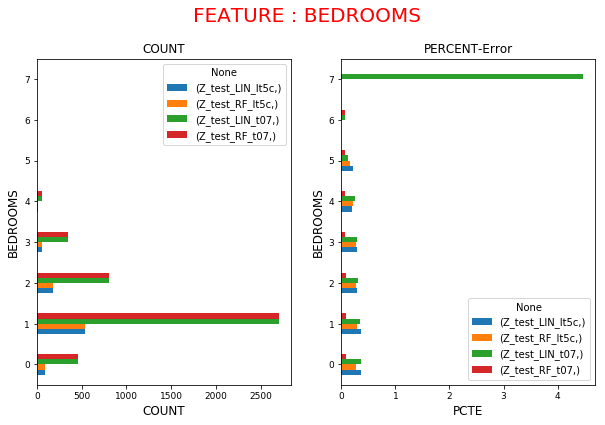

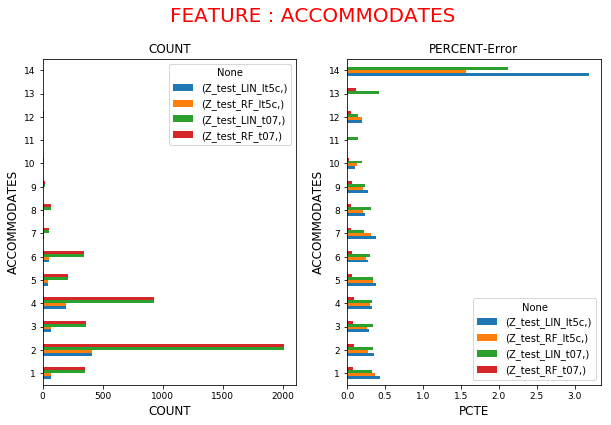

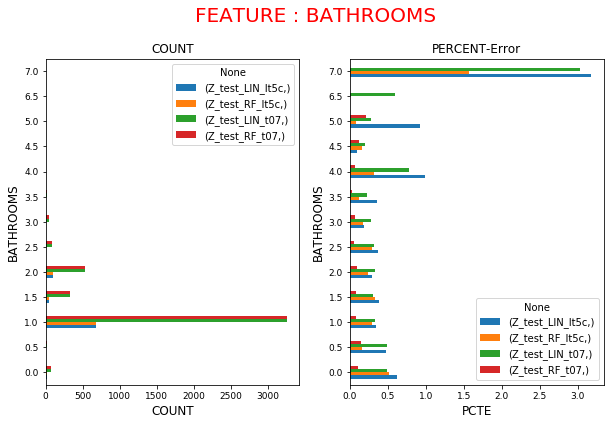

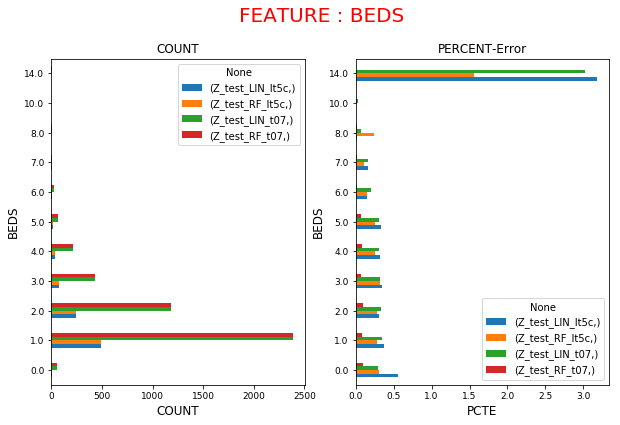

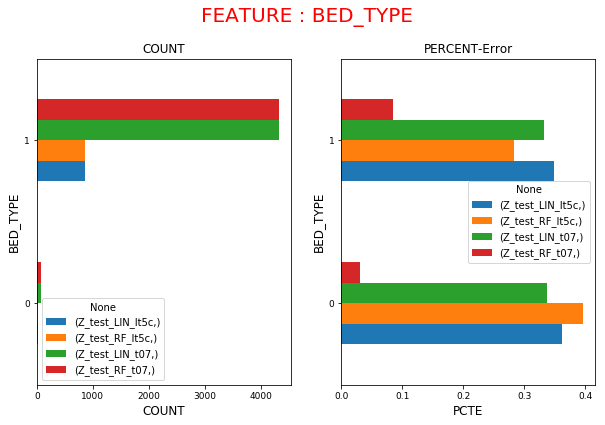

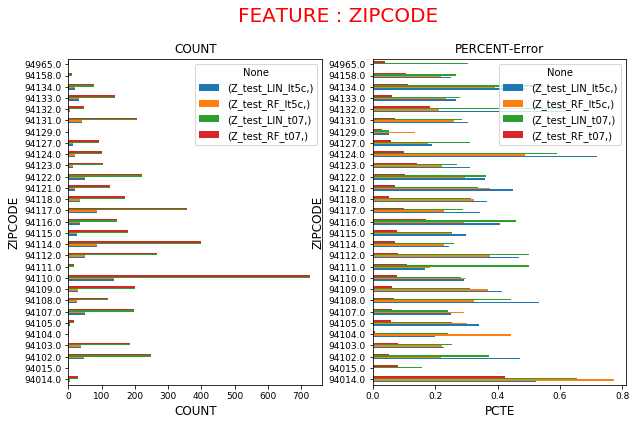

In [12]:
def pred_analysis(pred_list,mdl_data):

    featurelist=['bedrooms','accommodates','bathrooms','beds','bed_type','zipcode']
#     featurelist=['bedrooms']

    for fname in featurelist:
        pred_feature(pred_list,fname)

    # pred_feature(pred_list,'bedrooms')
    # pred_feature(pred_list,'accommodates')



print('ANALYZING PREDICTIONS !!!!!!!!!!!!!')
# pred_analysis([Z_test_LIN_lt5c,Z_test_LIN_t07],'linonly')
pred_analysis([Z_test_LIN_lt5c,Z_test_RF_lt5c,Z_test_LIN_t07,Z_test_RF_t07],'allmdls')

#     pred_analysis([Z_test_LIN_lt5c,Z_test_RF_lt5c,Z_test_GB_lt5c,Z_test_LIN_t07,Z_test_RF_t07,Z_test_GB_t07],'allmdls')
print('MODELLING PROCESS COMPLETE !!!!!!!!!!!!!!!!!!!!!!! ')
